In [1]:
import gc
import os
import ccxt
import talib
import optuna
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from os import getenv
from dotenv import load_dotenv

from config import ccxt_connect
from helper import vwap, long_short

load_dotenv()

exchange = ccxt_connect()

In [2]:
exchange.get_balance()

AttributeError: 'binanceus' object has no attribute 'get_balance'

In [56]:
data = pd.read_parquet('data/eth_data.parquet')

last_date = int(round(data['date'].iloc[-1].timestamp() * 1000)) + 1

new_data_query = exchange.fetch_ohlcv('ETH/USDT', '5m', limit=250, since=last_date)

new_data = pd.DataFrame(new_data_query[:-1], columns=['at', 'open', 'high', 'low', 'close', 'vol'])
new_data['date'] = pd.to_datetime(new_data['at'], unit='ms')
new_data.drop('at', axis=1, inplace=True)

if len(new_data) > 0:
    data = pd.concat([data, new_data])
    data.reset_index()
    data.to_parquet('data/eth_data.parquet')

data = pd.read_parquet('data/eth_data.parquet')

In [62]:
df = data.copy()
df.set_index('date', inplace=True)
close = df['close'].values
df['rsi'] = talib.RSI(close, timeperiod=14)
#df['BB_up'], df['BB_mid'], df['BB_low'] = talib.BBANDS(close, timeperiod=20, nbdevup=2.3, nbdevdn=2.3, matype=0)
df['macd'], df['macdsignal'], df['macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
#df['atr'] = talib.ATR(df['high'].values, df['low'].values, close, timeperiod=14)
#df['obv'] = talib.OBV(close, df['vol'].values)
df['EMA9'] = talib.EMA(df.close, 9)
df['EMA55'] = talib.EMA(df.close, 55)
df['EMA200'] = talib.EMA(df.close, 200)

df['date'] = df.index
df.reset_index(drop=True, inplace=True)
df.fillna(method='ffill', inplace=True)
df = df.iloc[-200:][['date', 'close', 'rsi', 'macdhist', 'EMA9', 'EMA55', 'EMA200']]

#vwap = vwap(df)

#df = df.merge(vwap, on='date', how='left')
df['signal'] = df.apply(long_short, axis=1)

In [63]:
df

,date,close,rsi,macdhist,EMA9,EMA55,EMA200,signal
61947,2022-12-16 10:00:00,1212.02,20.995397,-0.168335,1215.181519,1249.094418,1265.620113,Short
61948,2022-12-16 10:05:00,1211.10,20.510066,0.293341,1214.365216,1247.737474,1265.077624,None
61949,2022-12-16 10:10:00,1209.51,19.664046,0.602336,1213.394172,1246.372208,1264.524713,None
61950,2022-12-16 10:15:00,1211.87,24.633315,1.050140,1213.089338,1245.139986,1264.000785,None
61951,2022-12-16 10:20:00,1212.36,25.661486,1.439741,1212.943470,1243.969272,1263.486947,None
...,...,...,...,...,...,...,...,...
62142,2022-12-17 02:15:00,1165.91,37.870174,-0.442715,1168.426288,1176.084967,1199.409981,Short
62143,2022-12-17 02:20:00,1163.63,34.262648,-0.583645,1167.467031,1175.640147,1199.053962,Short
62144,2022-12-17 02:25:00,1162.90,33.173040,-0.672778,1166.553625,1175.185142,1198.694221,Short
62145,2022-12-17 02:30:00,1169.84,49.586993,-0.233759,1167.210900,1174.994244,1198.407114,None


<AxesSubplot:xlabel='date'>

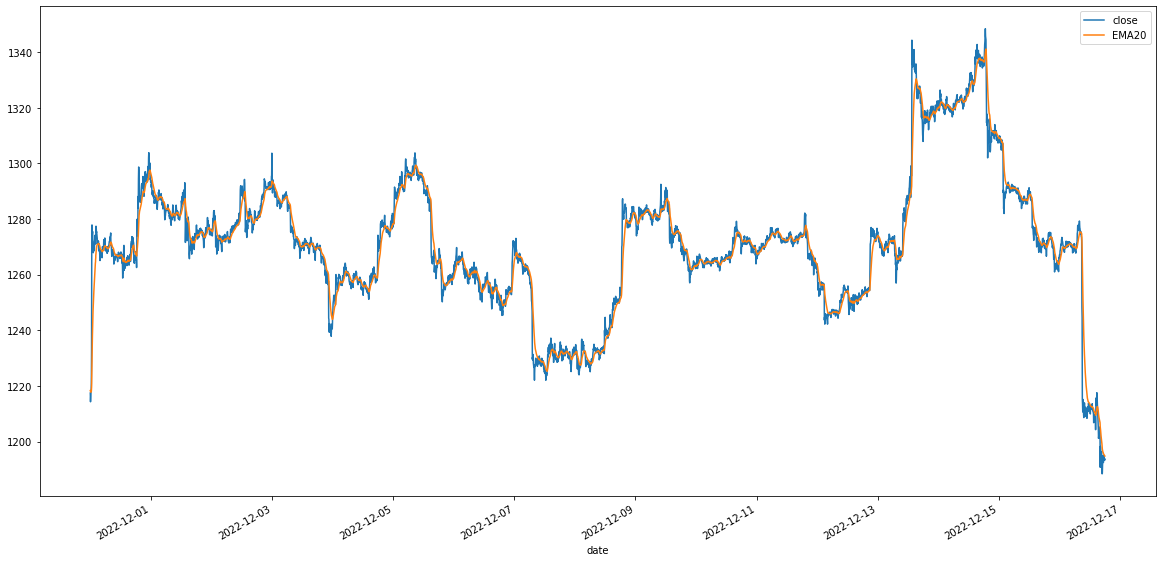

In [30]:
df.plot(y=['close', 'EMA20'], x='date', figsize=(20, 10))

In [52]:
df.to_csv('check.csv', index=False)